In [ ]:
#| default_exp viz

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import torch
import cv2
import numpy as np
import kornia

from kornia.utils import tensor_to_image, image_to_tensor
from typing import List, Union, Tuple, Optional
from copy import deepcopy

import matplotlib.pyplot as plt
import torch.nn as nn
from torch import allclose
from typing import Union



In [ ]:
from kornia_moons.feature import (
    to_numpy_image,
    to_torch,
    to_np,
    laf_from_opencv_kpts,
    opencv_kpts_from_laf,
    laf_from_opencv_ORB_kpts,
    cv2_matches_from_kornia,
    laf_from_opencv_SIFT_kpts)

In [ ]:
#| export


def visualize_LAF(img, LAF, img_idx = 0, color='r', draw_ori = True, **kwargs):
    from kornia_moons.feature import to_numpy_image
    x, y = kornia.feature.laf.get_laf_pts_to_draw(kornia.feature.laf.scale_laf(LAF, 0.5), img_idx)
    if not draw_ori:
        x= x[1:]
        y= y[1:]
    fig = plt.figure(**kwargs)
    plt.imshow(to_numpy_image(img[img_idx]))
    plt.plot(x, y, color)
    plt.show()
    return fig


Let's detect ORB keypoints and convert them to and from OpenCV

libpng warning: iCCP: known incorrect sRGB profile


<matplotlib.image.AxesImage>

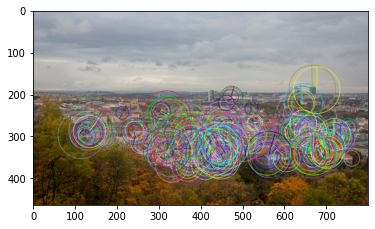

In [ ]:
img = cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB)

det = cv2.ORB_create(500)
kps, descs = det.detectAndCompute(img, None)

out_img = cv2.drawKeypoints(img, kps, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

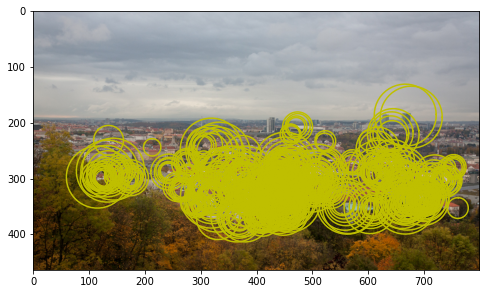

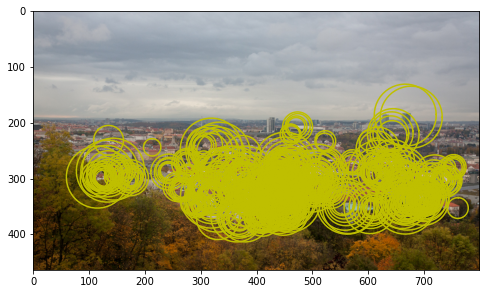

In [ ]:
lafs, r = laf_from_opencv_kpts(kps, 1.0, with_resp=True)
visualize_LAF(image_to_tensor(img, False), lafs, 0, 'y', draw_ori=False, figsize=(8,6))

<matplotlib.image.AxesImage>

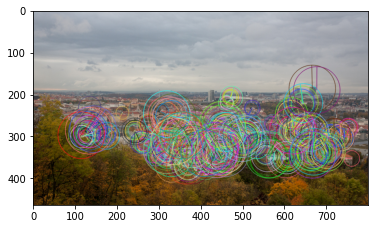

In [ ]:
kps_back = opencv_kpts_from_laf(lafs, 1.0, r)
out_img = cv2.drawKeypoints(img, kps_back, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
plt.imshow(out_img)

OpenCV uses different conventions for the local feature scale. 

E.g. to get equivalent kornia LAF from ORB keypoints, one should you mrSize = 0.5, 
while for SIFT -- 6.0. The orientation convention is also different for kornia and OpenCV.

In [ ]:
#| export 
def epilines_to_start_end_points(epi, h, w):
    num = len(epi)
    zeros = torch.zeros(num)
    ones = torch.ones(num)
    eps = 1e-8

    
    b = -epi[:,2] / (epi[:,1] + eps)
    k = -epi[:,0] / (epi[:,1] + eps)
    k_positive = k >= 0
    k_negative = k < 0
    
    
    # We find the points of crossing x = 0, x = w, y = 0, y = h
    p1 = torch.stack([zeros,  b], axis=-1)
    p2 = torch.stack([w*ones, k*w + b], axis =-1)
    p3 = torch.stack([-b/(k + eps), zeros], axis=-1)
    p4 = torch.stack([(h - b)/(k + eps), ones*h], axis=-1)
    
    # Now we select those, which are inside of image
    p1_is_start = (p1[:, 1:2] <= h) & (p1[:, 1:2] >= 0)
    p3_is_start = (k_positive * (~p1_is_start.view(-1))).view(-1,1)
    p4_is_start = (k_negative * (~p1_is_start.view(-1))).view(-1,1)
    none_is_start = ~(p1_is_start | p3_is_start |  p4_is_start)
    
    
    p2_is_fin  = (p2[:, 1:2] <= h) & (p2[:, 1:2] >= 0)
    p4_is_fin  = (k_positive * (~p2_is_fin.view(-1))).view(-1,1)
    p3_is_fin  = (k_negative * (~p2_is_fin.view(-1))).view(-1,1)
    
    
    start_lines = p1 * p1_is_start.float() + p3 * p3_is_start.float() + p4 * p4_is_start.float()
    fin_lines   = p2 * p2_is_fin.float()   + p4 * p4_is_fin.float() + p3 * p3_is_fin.float()
    return torch.stack ([start_lines, fin_lines])

In [ ]:
#| export
import kornia as K
import kornia.feature as KF
import torch
def draw_LAF_matches(lafs1, lafs2, tent_idxs,  
                     img1, img2, inlier_mask = None, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                                  "vertical": False}, 
                        Fm: Optional[np.array] = None, H: Optional[np.array] = None,
                        ax: Optional = None,
                        return_axis=False):
    '''This function draws LAFs, tentative matches, inliers epipolar lines (if F is provided),
    and image1 corners reprojection into image 2 (if H is provided)'''
    if inlier_mask is not None:
        inlier_mask = np.array(inlier_mask).reshape(-1)
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)
    
    h,w = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    corners_pts = np.float32([[0, 0],
                              [0, h-1],
                              [w-1, h-1],
                              [w-1, 0],
                              [0, 0] ]).reshape(-1,1,2)
        
    
    img2_tr = deepcopy(img2)
    
    xy1 = KF.get_laf_center(to_torch(lafs1)).reshape(-1, 2)
    xy2 = KF.get_laf_center(to_torch(lafs2)).reshape(-1, 2)
    # If we have no axes, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,10))

    tent_cv2 = cv2_matches_from_kornia(torch.ones(len(tent_idxs)), tent_idxs)
    tent_corrs = torch.stack([xy1[tent_idxs[:,0]], xy2[tent_idxs[:,1]]])
    try:
        vert = draw_dict['vertical']
    except:
        vert = False
    if vert:
        tent_corrs[1,:,1]+=h # shift for the 2nd image
    else:
        tent_corrs[1,:,0]+=w # shift for the 2nd image
    if H is not None:
        dst_corners = cv2.perspectiveTransform(corners_pts, H)
        if vert:
            dst_corners[...,1]+=h
        else:
            dst_corners[...,0]+=w
    # Prepraring canvas
    if not vert:
        if len(img1.shape) == 3:
            new_shape = (max(h, h2), w + w2, img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (max(h, h2), w + w2)
    else:
        if len(img1.shape) == 3:
            new_shape = (h + h2,  max(w, w2), img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (h + h2,  max(w, w2))        
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    if not vert:
        new_img[0:h, 0:w] = img1
        new_img[0:h2, w:w + w2] = img2
    else:
        new_img[0:h, 0:w] = img1
        new_img[h:h+h2, 0:w2] = img2

    x1, y1 = to_np(KF.laf.get_laf_pts_to_draw(lafs1, 0))
    x2, y2 = to_np(KF.laf.get_laf_pts_to_draw(lafs2, 0))
    if vert:
        y2+=h
    else:
        x2+=w
    # Drawing features
    try:
        fc = draw_dict['feature_color']
    except:
        fc = None
    if fc is not None:
        ax.plot(x1, y1, color=fc)
        ax.plot(x2, y2, color=fc)
        
    #Drawgin tentatives
    try:
        tc = draw_dict['tentative_color']
    except:
        tc = None
    if tc is not None:
        ax.plot(tent_corrs[...,0], tent_corrs[...,1], color=tc)
        ax.plot(x1[:, tent_idxs[:,0]], y1[:, tent_idxs[:,0]], color=tc)
        ax.plot(x2[:, tent_idxs[:,1]], y2[:, tent_idxs[:,1]], color=tc)
    try:
        ic = draw_dict['inlier_color']
    except:
        ic = None
    if (ic is not None) and (inlier_mask is not None):
        inlier_mask = inlier_mask > 0
        ax.plot(tent_corrs[..., inlier_mask, 0], tent_corrs[...,inlier_mask, 1], color=ic)
        ax.plot(x1[:, tent_idxs[inlier_mask,0]], y1[:, tent_idxs[inlier_mask,0]], color=ic)
        ax.plot(x2[:, tent_idxs[inlier_mask,1]], y2[:, tent_idxs[inlier_mask,1]], color=ic)
    if H is not None:
        ax.plot(corners_pts[:,0,0], corners_pts[:,0,1], color=(0,0,1))
        ax.plot(dst_corners[:,0,0], dst_corners[:,0,1], color=(0,0,1))
    if (Fm is not None):
        if inlier_mask is None:
            inlier_mask = [True for i in range(len(tent_idxs))]
        tent_corrs2 = torch.stack([xy1[tent_idxs[:,0]], xy2[tent_idxs[:,1]]])
        inl1 = tent_corrs2[0, inlier_mask]
        inl2 = tent_corrs2[1, inlier_mask]
        Ff = torch.from_numpy(Fm).float()
        epi1 = K.geometry.compute_correspond_epilines(inl2.reshape(1,-1, 2), Ff.t()[None])[0]
        epiline1 = epilines_to_start_end_points(epi1, h, w)
        
        epi2 = K.geometry.compute_correspond_epilines(inl1.reshape(1,-1, 2), Ff[None])[0]
        epiline2 = epilines_to_start_end_points(epi2, h2, w2)
        if vert:
            epiline2[...,1]+=h # shift for the 2nd image
        else:
            epiline2[...,0]+=w # shift for the 2nd image            
        
        ax.plot(epiline1[:,:,0], epiline1[:,:,1], color='purple')
        ax.plot(epiline2[:,:,0], epiline2[:,:,1], color='purple')
    # Finally clip the image
    ax.imshow(new_img)
    if not vert:
        ax.set_xlim([0,w+w2])
        ax.set_ylim([max(h,h2),0])
        ax.margins(0,0)
    else:
        ax.set_xlim([0,max(w,w2)])
        ax.set_ylim([h+h2, 0])
        ax.margins(0,0)
    if return_axis:
        return ax
    return 

We will visualize ORB features (blue), tentative matches (yellow) and inliers(greenish)

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


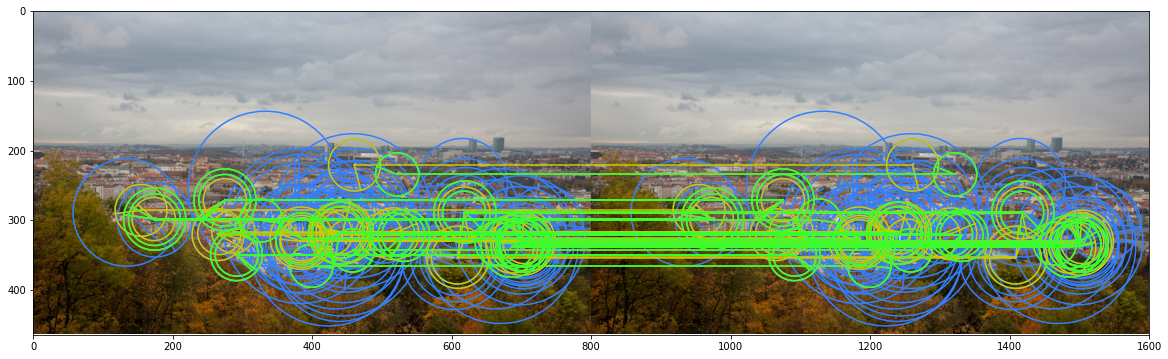

In [ ]:
import numpy as np
det = cv2.ORB_create(100)
img1_fname = 'data/strahov.png'
kps1, descs1 = det.detectAndCompute(cv2.imread(img1_fname,0), None)
lafs1 = laf_from_opencv_ORB_kpts(kps1)
idxs = torch.stack([torch.arange(50),torch.arange(50)], dim=-1)
draw_LAF_matches(lafs1, lafs1, idxs,
                  img1_fname,img1_fname, 
                  [True if i%2 == 0 else False for i in range(len(idxs))],
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                              "vertical": False})

Now let's try with epipolar matrix for the translation. Inliers should lie on the horizontal epipolar lines

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


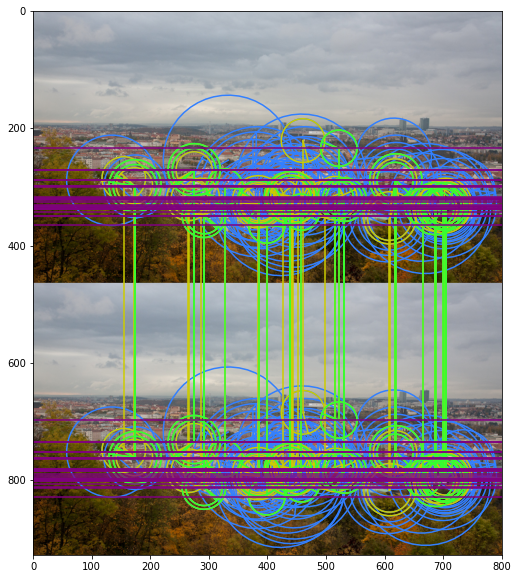

In [ ]:
Fmat = np.array([[0., 0., 0.],
                 [0, 0, -1],
                [0, 1, 0]])
draw_LAF_matches(lafs1, lafs1, idxs,
                  img1_fname,img1_fname, 
                  [True if i%2 == 0 else False for i in range(len(idxs))],
                    draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                              "vertical": True}, Fm = Fmat)

Now we will transform the image, match it, find the homography and visualize it.

libpng warning: iCCP: known incorrect sRGB profile


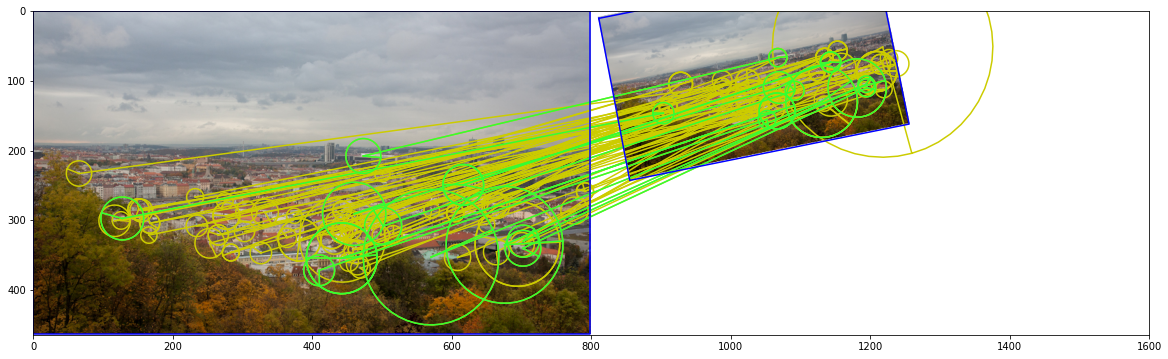

In [ ]:
import numpy as np
det = cv2.SIFT_create(100)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.5, 0.1, 10],
                [-0.1, 0.5, 10],
               [0, 0, 1]])
img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))



kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)


match_dists, match_idxs = kornia.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.98)

H, mask = cv2.findHomography(kornia.feature.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             kornia.feature.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_matches(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask,
                  draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": None,
                              "vertical": False}, H = H)

And the same with fundamental matrix

libpng warning: iCCP: known incorrect sRGB profile


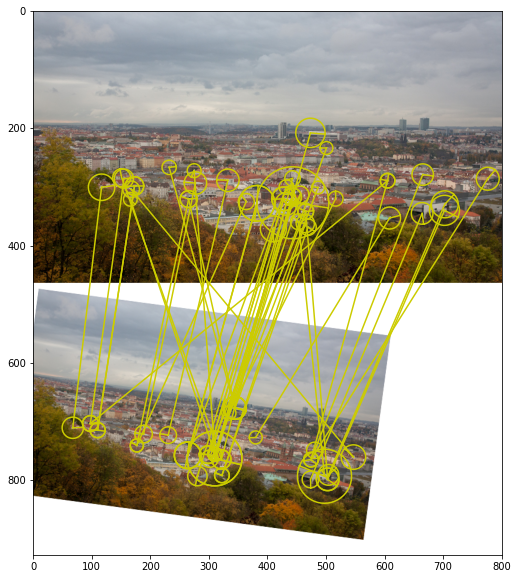

In [ ]:
import numpy as np
det = cv2.SIFT_create(75)
img1_fname = 'data/strahov.png'
img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)

Hgt = np.array([[0.75, -0.1, 10],
                [0.1, 0.75, 10],
               [0, 0, 1]])

img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))


kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)

kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)



match_dists, match_idxs = kornia.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.95)

Fmat, mask = cv2.findFundamentalMat(kornia.feature.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             kornia.feature.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_matches(lafs1, lafs2, match_idxs,
                  img1, img2, 
                  mask,
                  draw_dict={"inlier_color": None,#(0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": None,
                              "vertical": True})

In [ ]:
#| export
def draw_LAF_matches_from_result_dict(result_dict,
                        img1, img2, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "tentative_color": (0.8, 0.8, 0), 
                               "feature_color": (0.2, 0.5, 1),
                                  "vertical": False}):
    if 'H' in result_dict:
        H = result_dict['H']
    else:
        H = None
    if 'F' in rbesult_dict:
        Fm = result_dict['F']
    else:
        Fm = None
    return draw_LAF_matches(result_dict['feat_dict1']['lafs'], 
                        result_dict['feat_dict2']['lafs'],
                               result_dict['tents_dict']['idxs'],  
                        img1, img2, result_dict['inlier_mask'], 
                        draw_dict, Fm, H)

In [ ]:
#| export
def draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, tent_idxs,  
                        img1, img2, inlier_mask = None, 
                        draw_dict={"inlier_color": (0.2, 1, 0.2),
                               "reprojected_color": (0.2, 0.5, 1),
                                "vertical": False}, 
                        H: np.array = None,
                        ax: Optional = None,
                        return_axis = False):
    '''This function draws tentative matches and inliers given the homography H'''
    import kornia as K
    import kornia.feature as KF
    import kornia.geometry as KG
    inlier_mask = np.array(inlier_mask).reshape(-1)
    img1 = to_numpy_image(img1)
    img2 = to_numpy_image(img2)
    
    h,w = img1.shape[:2]
    h2,w2 = img2.shape[:2]
    
    img2_tr = deepcopy(img2)
    
    lafs1_in2 = KF.perspective_transform_lafs(torch.from_numpy(H).float()[None],
                                              lafs1)
    lafs2_in1 = KF.perspective_transform_lafs(torch.inverse(torch.from_numpy(H).float()[None]),
                                              lafs2)
    xy1 = KF.get_laf_center(lafs1).reshape(-1, 2)
    xy2 = KF.get_laf_center(lafs2).reshape(-1, 2)
    
    # If we have no axes, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=(20,10))

    tent_corrs_in1 = torch.stack([xy1[tent_idxs[:,0]],
                                  KF.get_laf_center(lafs2_in1).reshape(-1, 2)[tent_idxs[:,1]]])
    
    tent_corrs_in2 = torch.stack([KF.get_laf_center(lafs1_in2).reshape(-1, 2)[tent_idxs[:,0]],
                                  xy2[tent_idxs[:,1]]])
    
    try:
        vert = draw_dict['vertical']
    except:
        vert = False
    if vert:
        tent_corrs_in2[:,:,1]+=h # shift for the 2nd image
    else:
        tent_corrs_in2[:,:,0]+=w # shift for the 2nd image
    # Prepraring canvas
    if not vert:
        if len(img1.shape) == 3:
            new_shape = (max(h, h2), w + w2, img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (max(h, h2), w + w2)
    else:
        if len(img1.shape) == 3:
            new_shape = (h + h2,  max(w, w2), img1.shape[2])
        elif len(img1.shape) == 2:
            new_shape = (h + h2,  max(w, w2))        
    new_img = np.zeros(new_shape, type(img1.flat[0]))  
    # Place images onto the new image.
    if not vert:
        new_img[0:h, 0:w] = img1
        new_img[0:h2, w:w + w2] = img2
    else:
        new_img[0:h, 0:w] = img1
        new_img[h:h+h2, 0:w2] = img2

    x1,y1 = to_np(KF.laf.get_laf_pts_to_draw(lafs1, 0))
    x2,y2 = to_np(KF.laf.get_laf_pts_to_draw(lafs2, 0))
    
    x1in2, y1in2 = to_np(KF.laf.get_laf_pts_to_draw(lafs1_in2, 0))
    x2in1, y2in1 = to_np(KF.laf.get_laf_pts_to_draw(lafs2_in1, 0))
    
    if vert:
        y2+=h
        y1in2+=h
    else:
        x2+=w
        x1in2+=w
        
    try:
        ic = draw_dict['inlier_color']
    except:
        ic = None
    if (ic is not None) and (inlier_mask is not None):
        inlier_mask = inlier_mask > 0
        ax.plot(tent_corrs_in1[..., inlier_mask, 0], tent_corrs_in1[...,inlier_mask, 1], color=ic)#, markersize=15, marker='x')
        ax.plot(tent_corrs_in2[..., inlier_mask, 0],
                tent_corrs_in2[...,inlier_mask, 1], color=ic)#, markersize=15, marker='x')
        ax.plot(x1[:, tent_idxs[inlier_mask,0]], y1[:, tent_idxs[inlier_mask,0]], color=ic)#, markersize=15)
        ax.plot(x2[:, tent_idxs[inlier_mask,1]], y2[:, tent_idxs[inlier_mask,1]], color=ic)# markersize=15)
    try:
        rc = draw_dict['reprojected_color']
    except:
        rc = None
    if rc is not None:
        inlier_mask = inlier_mask > 0
        ax.plot(x1in2[:, tent_idxs[inlier_mask,0]], y1in2[:, tent_idxs[inlier_mask,0]], color=rc)#, markersize=15)
        ax.plot(x2in1[:, tent_idxs[inlier_mask,1]], y2in1[:, tent_idxs[inlier_mask,1]], color=rc)#, markersize=15)

    # Finally clip the image
    ax.imshow(new_img)
    if not vert:
        ax.set_xlim([0,w+w2])
        ax.set_ylim([max(h,h2),0])
        ax.margins(0,0)
    else:
        ax.set_xlim([0,max(w,w2)])
        ax.set_ylim([h+h2, 0])
        ax.margins(0,0)
    if return_axis:
        return ax
    return 

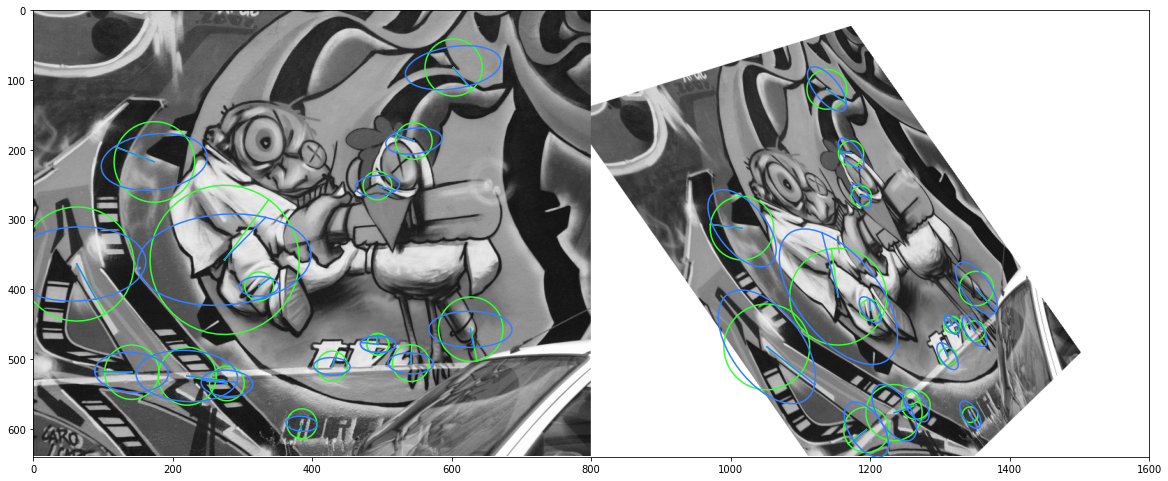

In [ ]:

det = cv2.SIFT_create(500)
img1_fname = 'data/img1.ppm'
img2_fname = 'data/img4.ppm'


img1 = cv2.cvtColor(cv2.imread(img1_fname), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread(img2_fname), cv2.COLOR_BGR2RGB)



Hgt = np.loadtxt('data/H1to4p')
img2 = cv2.warpPerspective(img1, Hgt, img1.shape[:2][::-1], borderValue=(255,255,255))



kps1, descs1 = det.detectAndCompute(img1, None)
lafs1 = laf_from_opencv_SIFT_kpts(kps1)
kps2, descs2 = det.detectAndCompute(img2, None)
lafs2 = laf_from_opencv_SIFT_kpts(kps2)


match_dists, match_idxs = kornia.feature.match_snn(torch.from_numpy(descs1).float(),
                                              torch.from_numpy(descs2).float(), 0.98)

H, mask = cv2.findHomography(kornia.feature.get_laf_center(lafs1[:,match_idxs[:,0]]).detach().cpu().numpy().reshape(-1,2),
                             kornia.feature.get_laf_center(lafs2[:,match_idxs[:,1]]).detach().cpu().numpy().reshape(-1,2),
                             cv2.USAC_MAGSAC, 0.5)

                             
draw_LAF_inliers_perspective_repjojected(lafs1, lafs2, match_idxs,
                  cv2.cvtColor(cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB),
                  cv2.cvtColor(cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB),
                  mask, H = H)

In [ ]:
#| export 
def draw_epipolar_errors_in_single_image(kp1: np.array, kp2: np.array,
                                         Fm1to2: np.array, img,
                                          draw_dict={"error_color": (1, 0.2, 0.2),
                                                     "feature_color": (0.2, 0.5, 1),
                                                     "figsize": (10,10),
                                                     "markersize": 8},
                                         img_index: int = 2,
                                         ax: Optional = None,
                                         title = None):
    '''This function draws epipolar errors in single image'''
    from kornia.geometry.epipolar import get_closest_point_on_epipolar_line
    img = to_numpy_image(img)
    pts1 = to_torch(kp1)[None]
    pts2 = to_torch(kp2)[None]
    Fm = to_torch(Fm1to2)
    if len(Fm.shape) == 2:
        Fm = Fm[None]
    assert img_index in [1,2]
    if img_index == 1:
        pts1, pts2 = pts2, pts1
        Fm = Fm.transpose(1, 2)
    closest_pts = get_closest_point_on_epipolar_line(pts1, pts2, Fm)
    
    # If we have no axes, create one
    if ax is None:
        fig, ax = plt.subplots(figsize=draw_dict["figsize"])
    ax.imshow(img)
    plt.scatter(pts2[0, :, 0].numpy(),
                pts2[0, :, 1].numpy(),
                s=draw_dict["markersize"]**2,
                label='GT points',
                color = draw_dict['feature_color'])
    plt.scatter(closest_pts[0, :, 0].numpy(),
                closest_pts[0, :, 1].numpy(),
                s=draw_dict["markersize"]**2,
                label='est. projection',
                color = draw_dict['error_color'], marker='x')

    plt.plot(torch.cat([pts2[0, :, 0].view(1,-1),
                        closest_pts[0, :, 0].view(1,-1)],dim=0).numpy(),
             torch.cat([pts2[0, :, 1].view(1,-1),
                        closest_pts[0, :, 1].view(1,-1)], dim=0).numpy(),
             label='error', color=draw_dict['error_color'])

    plt.legend(['GT points','est. projection','errors'])
    if title is not None:
        plt.title(title)
    return ax

libpng warning: iCCP: known incorrect sRGB profile


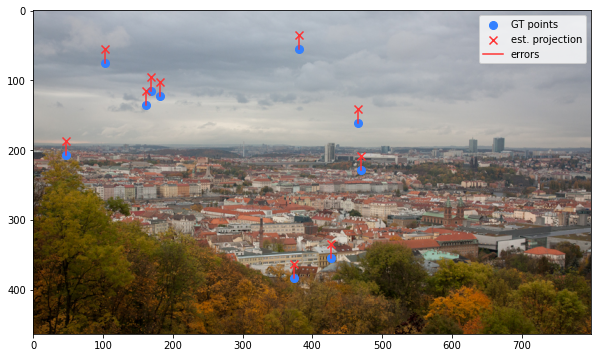

In [ ]:
kps1 = np.random.randint(0, 450, (10, 2)).astype(np.float32)
kps2 = kps1 + np.array([20., 20.]).astype(np.float32)

timg = image_to_tensor(cv2.cvtColor(cv2.imread('data/strahov.png'), cv2.COLOR_BGR2RGB), False).float()/255.
Fm = torch.tensor([[0, 0, 0],
                  [0, 0, 1],
                  [0, -1, 0.]]).float()

ax = draw_epipolar_errors_in_single_image(kps1, kps2, Fm, timg)

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()